# Plots of specific static energy vs. mass (pressure)

Dry static energy (s= CpT + gZ), water vapor mixing ratio (q), and therefore moist static energy (h= s + Lq) are useful for these reasons: 

1. They are conserved for vertical motions (air parcel pressure changes), like dry and moist entropy, or theta and theta-e in the potential temperature treatment of thermodynamics. 

2. They mix linearly: hmix = (h1+h2)/2 for equal mixtures between air parcels with h1 and h2. 

Because pressure is a mass coordinate, area on such a diagram is proportional to column integrated energy (J/ m^2). For instance, the total latent energy L*CWV or simply CWV (precipitable water) is the blue area in the diagram. The approximations in this system are that Cp and the denominator of vapor content (mixing ratio, not specific humidity) are treated as constants (the dry-air values). Also, L is also taken as constant (at the reference temperature). Z is related to pressure by the hydrostatic approximation. These approximations are acceptable for all conditions on Earth, including lifted-parcel buoyancy computations for inferring convection, as verifiable by comparing to the comparable theta, theta-e, theta-e-sat diagram readily computed from the sophisticated nonlinear-LOOKING formulas for those. All those complicated apparent nonlinearities can be scrapped in favor of this lucid, linear "energy in buckets" reasoning to very good approximation, as most researchers know well (and choose for their own clarity). 

In [1]:
def EnergyMassPlot(dataset):
    
### Plot specific (per unit mass) static energies, as a function of pressure (mass)

    import matplotlib.pyplot as plt
    import numpy as np
    import metpy.calc as mpcalc
    import metpy.units as mpunits
    from metpy.constants import Cp_d, Rd, Lv, g

    
    # FIGURE SETUP
    fig, ax = plt.subplots(figsize=(11,8))

    ### Set up axes  
    ax.axis([250,400, 1050,100])
    right_annot_loc = 380
    
    ### Turn on and locate RCE reference annotations (thermo. energy = area on the diagram)
    RCE_ref = 'true'
    RCEloc = 260 # kJ/kg location on plot


    ### Label axes  
    ax.set_title('Conserved variables diagram: static energy')
    ax.set_xlabel(
        'specific static energies: $\mathregular{s, s_v, h, h_{sat} \/(kJ\/kg^{-1})}$')
    ax.set_ylabel('p (hPa)')
 

    ### Some non-data-dependent standard annotations
    if(RCE_ref):
        ### Energy is area, draw reference boxes. 
        ax.plot    ([RCEloc,RCEloc],[0,1100], linewidth=0.5) ### thin reference line
        ax.annotate('daily RCE', xy=(RCEloc,1045), horizontalalignment='center')


        #### Radiative cooling reference
        ax.fill([RCEloc  , RCEloc -1.3, RCEloc -1.3, RCEloc, RCEloc ],             
                [1000 , 1000    , 200     , 200, 1000],             
                linewidth=1, color='c', alpha=0.9)

        ax.annotate(' cooling $-1.3 K/d$',  xy=(RCEloc, 300), color='c')
        ax.annotate('$-10^7 J m^{-2}$', xy=(RCEloc, 330))

        #### Surface flux reference
        ax.fill([RCEloc  , RCEloc +11, RCEloc +11, RCEloc, RCEloc ],             
                [1000 , 1000   , 910    , 910, 1000],             
                linewidth=1, color='orange', alpha=0.5)

        ax.annotate(' heat flux', xy=(RCEloc,890), color='orange')
        ax.annotate('116 $W m^{-2}$', xy=(RCEloc,940))
        ax.annotate(' for 1 day'     , xy=(RCEloc,960), fontsize=9)
        ax.annotate('=$10^7 J m^{-2}$'  , xy=(RCEloc, 990))



        
    ### GRAB THE DATA
    p = dataset.variables['pressure'][:]
    T = dataset.variables['temperature'][:]
    Td = dataset.variables['dewpoint'][:]
    Z = dataset.variables['height'][:]
    u = dataset.variables['u_wind'][:]
    v = dataset.variables['v_wind'][:]


    ### The sounding data plot: need mixing ratios from T,Td
    q = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Td),p)
    qs= mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T),p)

    s = g*Z + Cp_d*T 
    sv= g*Z + Cp_d*mpcalc.virtual_temperature(T,q)
    h = s            + Lv*q
    hs= s            + Lv*qs

    ax.plot(s  /1000, p, color='r', linewidth=1.5)  ### /1000 for kJ/kg
    ax.plot(sv /1000, p, color='r', linestyle='-.') 
    ax.plot(h  /1000, p, color='b', linewidth=1.5) 
    ax.plot(hs /1000, p, color='r', linewidth=1.5) 


    ### RH rulings between s and h lines: annotate near 800 hPa level
    annot_level = 800 #hPa
    idx = np.argmin(np.abs(p - annot_level *mpunits.units.hPa))

    for iRH in np.arange(10,100,10):
        ax.plot( (s+ Lv*qs*iRH/100.)/1000, p, linewidth=0.5, linestyle=':', color='k')
        ax.annotate(str(iRH), xy=( (s[idx]+Lv*qs[idx]*iRH/100.)/1000, annot_level),                    
                    horizontalalignment='center',fontsize=6)
    ax.annotate('RH (%)', xy=(right_annot_loc, annot_level), fontsize=10)



    ### Lifted parcels in green, but only if there is undilute CAPE 
    # Calculate lifted undilute parcel temperatue profile.
    parcel_Tprofile = mpcalc.parcel_profile(p, T[0], Td[0]).to('degC')
    CAPE,CIN = mpcalc.cape_cin(p,T,Td,parcel_Tprofile)
    # print(CAPE,CIN)
    
    if ~np.isnan(CAPE.magnitude):
        if CAPE.magnitude>0:  
            parcelh  = h [0]        # for a layer mean: np.mean(h[idx1:idx2])
            parcelsv = sv[0]
            parcelp0 = p[0]

            # Undilute parcel
            ax.plot( (1,1)*parcelh/1000., (1,0)*parcelp0, linewidth=0.5, color='g')
            maxbindex = np.argmax(parcel_Tprofile - T)
            ax.annotate('CAPE='+str(int(CAPE.magnitude)), 
                        xy=(parcelh/1000., p[maxbindex]), color='g')

            # Plot LCL at saturation point, where a lifted sv parcel would go 
            lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
            ax.annotate('LCL', xy=(sv[0]/1000., lcl_pressure), fontsize=10, color='g', horizontalalignment='right')
            # Purple fill for negative buoyancy below LCL:
            ax.fill_betweenx(p, sv/1000., parcelsv/1000., where=p>lcl_pressure, facecolor='purple', alpha=0.4)

            # Positive moist convective buoyancy in green 
            # Above LCL:
            ax.fill_betweenx(p, hs/1000., parcelh/1000., where= parcelh>hs, facecolor='g', alpha=0.4)


            # Depict Entraining parcels
            # Parcel mass solves dM/dz = eps*M, solution is M = exp(eps*Z)
            entrainment_distance = 10000., 5000., 2000. 
            ax.annotate('entrain: 10,5,2 km',  xy=(parcelh/1000, 140), color='g', 
                        fontsize=8, horizontalalignment='right')
            ax.annotate('parcel h',            xy=(parcelh/1000, 120), color='g', 
                        fontsize=10, horizontalalignment='right')

            for ED in entrainment_distance: 
                eps = 1.0 / (ED*mpunits.units('m'))
                M = np.exp(eps * Z.to('m')).to('dimensionless')

                # dM is the mass contribution at each level, with 1 at the origin level. 
                M[0] = 0
                dM = np.gradient(M)

                # parcel mass is a  sum of all the dM's at each level
                # conserved linearly-mixed variables like h are weighted averages 
                hent = np.cumsum(dM*h) / np.cumsum(dM)

                ax.plot( hent/1000., p, linewidth=0.5, color='g')




    ### Internal waves (100m adiabatic displacements, assumed adiabatic: conserves s, sv, h). 
    dZ = 100 *mpunits.units.meter

    # depict displacements at sounding levels nearest these target levels
    targetlevels = [900,800,700,600,500,400,300,200]*mpunits.units.hPa
    for ilev in targetlevels:
        idx = np.argmin(np.abs(p - ilev))

        # dT: Dry lapse rate dT/dz_dry is -g/Cp
        dT = (-g/Cp_d *dZ).to('kelvin')    
        Tdisp = T[idx].to('kelvin') + dT

        # dp: hydrostatic
        rho = (p[idx]/Rd/T[idx])
        dp = -rho*g*dZ

        # dhsat
        #qs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(T)     ,p)
        dqs = mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(Tdisp) ,p[idx]+dp) -qs[idx]
        dhs = g*dZ + Cp_d*dT + Lv*dqs

        # Whiskers on the data plots
        ax.plot( (hs[idx]+dhs*(-1,1))/1000, p[idx]+dp*(-1,1), linewidth=3, color='r')  
        ax.plot( (s [idx]    *( 1,1))/1000, p[idx]+dp*(-1,1), linewidth=3, color='r')  
        ax.plot( (h [idx]    *( 1,1))/1000, p[idx]+dp*(-1,1), linewidth=3, color='b')  

        # annotation to explain it 
        if ilev == 600*ilev.units:
            ax.plot(right_annot_loc*hs.units +dhs*(-1,1)/1000, p[idx]+dp*(-1,1), linewidth=3, color='r')  
            ax.annotate('100m internal waves', xy=(right_annot_loc,600), fontsize=8)



    ### Blue fill proportional to precipitable water, and blue annotation
    ax.fill_betweenx(p, s/1000., h/1000., where=h > s, facecolor='b', alpha=0.4)

    import metpy.calc as mpcalc
    PW = mpcalc.precipitable_water(Td,p)
    PWs = mpcalc.precipitable_water(T,p)
    CRH = (PW/PWs).magnitude *100. 

    # PW annotation arrow tip at 700 mb
    idx = np.argmin(np.abs(p - 700*p.units))
    centerblue = (s[idx]+h[idx])/2.0 /1000.

    ax.annotate('CWV='+str(round(PW.to('mm').magnitude, 1))+'mm',
                xy=(centerblue, 700), xytext=(285, 200), 
                color='blue', fontsize=15,
                arrowprops=dict(width = 1, edgecolor='blue', shrink=0.02),
                )
    ax.annotate('(' + str(round(CRH,1)) +'% of sat)',
                xy=(285, 230), color='blue', fontsize=12)



    ### Surface water values at 1C intervals, for eyeballing surface fluxes
    sT = np.trunc(T[0].to('degC'))
    sTint = int(sT.magnitude)

    for idT in [-2,0,2,4]:
        ssTint = sTint + idT # UNITLESS degC integers, for labels

        # Kelvin values for computations
        ssTC = ssTint *mpunits.units('degC')
        ssTK = ssTC.to('kelvin')
        ss = g*Z[0] + Cp_d*ssTK 
        hs = ss     + Lv*mpcalc.mixing_ratio(mpcalc.saturation_vapor_pressure(ssTK) ,p[0])

        ax.annotate(str(ssTint), xy=(ss/1000., p[0]+0*p.units), 
                    verticalalignment='top', horizontalalignment='center',
                    color='red', fontsize=7)
        ax.annotate(str(ssTint), xy=(hs/1000., p[0]+0*p.units), 
                    verticalalignment='top', horizontalalignment='center',
                    color='red', fontsize=9)
        ax.annotate('\u00b0C water', xy=(right_annot_loc, p[0]), verticalalignment='top', 
                    fontsize=10, color='r')


    plt.show()


In [2]:
%matplotlib inline

/Users/johnleeman/miniconda3/envs/devel/lib/python3.6/site-packages/ipykernel_launcher.py:9: MetpyDeprecationWarning: The get_upper_air_data function was deprecated in version 0.6. This function is being moved to the Siphon package.
  if __name__ == '__main__':


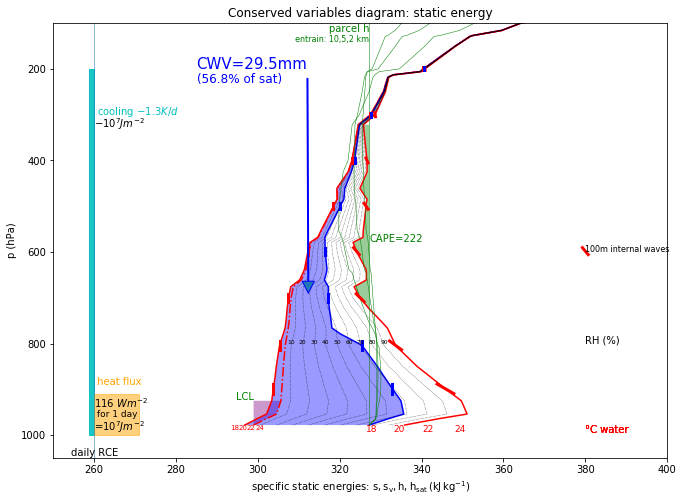

In [3]:
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import metpy.calc as mpcalc
import metpy.units as mpunits
from metpy.io import get_upper_air_data

# example from MetPy tutorial 
sounding = get_upper_air_data(datetime(2002, 11, 11, 0), 'BNA')
EnergyMassPlot(sounding)

/Users/johnleeman/miniconda3/envs/devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: MetpyDeprecationWarning: The get_upper_air_data function was deprecated in version 0.6. This function is being moved to the Siphon package.
  


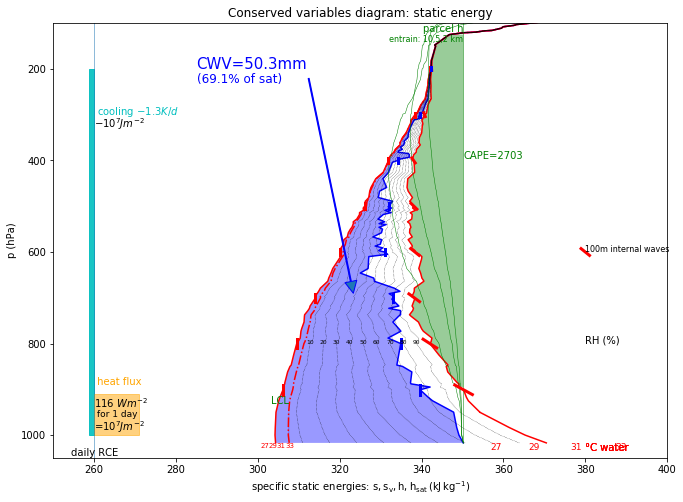

In [4]:
# Miami in summer
sounding = get_upper_air_data(datetime(2013, 8, 25, 0), 'MFL')
EnergyMassPlot(sounding)

/Users/johnleeman/miniconda3/envs/devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: MetpyDeprecationWarning: The get_upper_air_data function was deprecated in version 0.6. This function is being moved to the Siphon package.
  


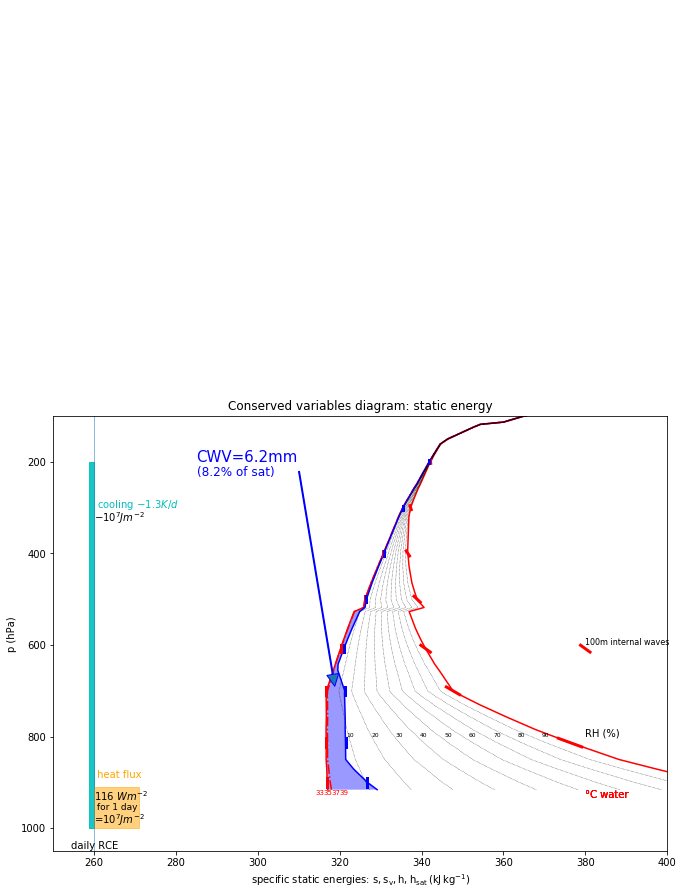

In [5]:
# Tucson in summer
sounding = get_upper_air_data(datetime(2002, 6, 10, 0), '72274')
EnergyMassPlot(sounding)

/Users/johnleeman/miniconda3/envs/devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: MetpyDeprecationWarning: The get_upper_air_data function was deprecated in version 0.6. This function is being moved to the Siphon package.
  


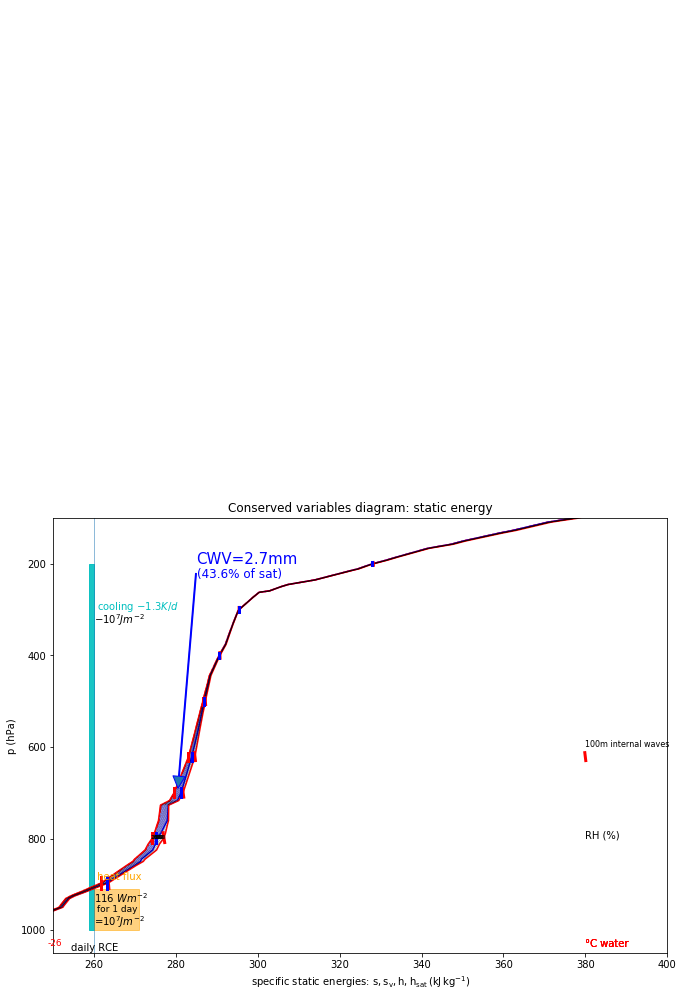

In [6]:
# Northern Canada in winter
sounding = get_upper_air_data(datetime(2002, 1, 26, 0), '71043')
EnergyMassPlot(sounding)

/Users/johnleeman/miniconda3/envs/devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: MetpyDeprecationWarning: The get_upper_air_data function was deprecated in version 0.6. This function is being moved to the Siphon package.
  
/Users/johnleeman/gitrepos/MetPy/metpy/calc/tools.py:703: RuntimeWarning: invalid value encountered in true_divide
  (xp[above] - xp[below])) * (var[above] -


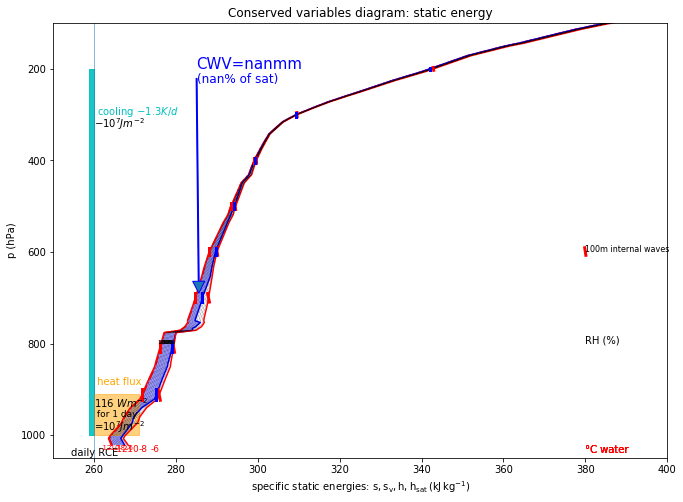

In [7]:
# Resolute, Canada in spring
sounding = get_upper_air_data(datetime(2002, 5, 10, 0), '71924')
EnergyMassPlot(sounding)

/Users/johnleeman/miniconda3/envs/devel/lib/python3.6/site-packages/ipykernel_launcher.py:2: MetpyDeprecationWarning: The get_upper_air_data function was deprecated in version 0.6. This function is being moved to the Siphon package.
  
/Users/johnleeman/gitrepos/MetPy/metpy/calc/tools.py:833: RuntimeWarning: invalid value encountered in less
  return np.less(a, value) | np.isclose(a, value, **kwargs)
/Users/johnleeman/miniconda3/envs/devel/lib/python3.6/site-packages/pint/quantity.py:1403: RuntimeWarning: invalid value encountered in less
  out = uf(*mobjs)
/Users/johnleeman/gitrepos/MetPy/metpy/calc/thermo.py:1020: RuntimeWarning: invalid value encountered in greater
  keep_idx = np.ediff1d(x, to_end=[1]) > 0
/Users/johnleeman/gitrepos/MetPy/metpy/calc/tools.py:811: RuntimeWarning: invalid value encountered in greater
  return np.greater(a, value) | np.isclose(a, value, **kwargs)
/Users/johnleeman/miniconda3/envs/devel/lib/python3.6/site-packages/pint/quantity.py:1403: RuntimeWarning:

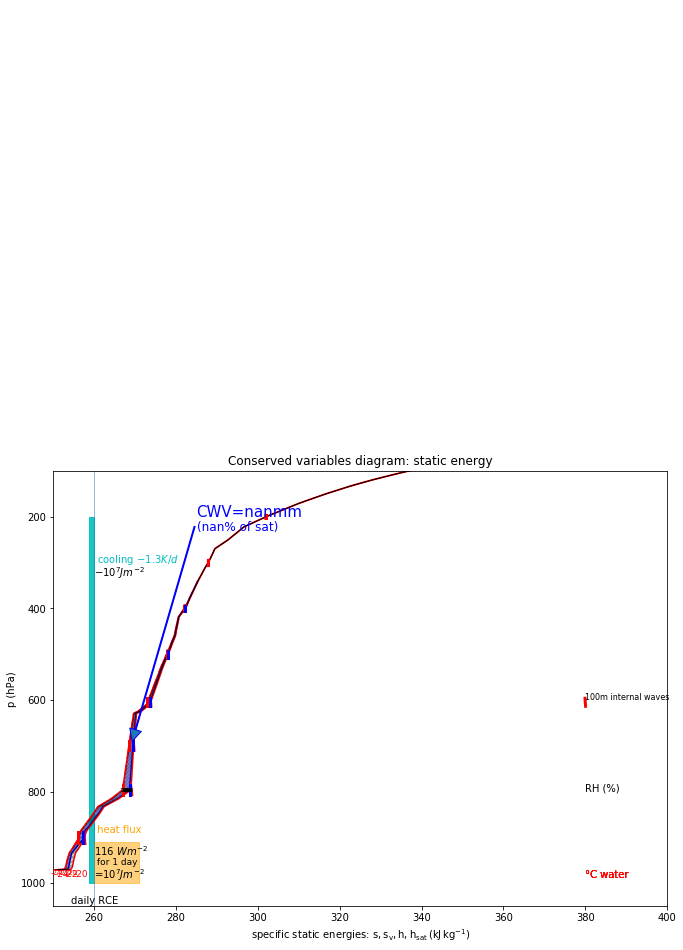

In [8]:
# Davis station in Antarctica 
sounding = get_upper_air_data(datetime(2010, 8, 1, 0), '89571')
EnergyMassPlot(sounding)